# Proyecto 03 - Sistemas de Recomendación


## Dataset: STEAM
## Consignas

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

## Parte A - Exploración de Datos

### 1. CONVERTIMOS ARCHIVOS JSON A CSV

In [1]:
#import gzip
#import pandas as pd

#def parse(path):
#    g = gzip.open(path, 'r')
#    for l in g:
#        yield eval(l)

#### 1.1 REVIEWS

In [2]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10
#for l in parse('steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1

In [3]:
#data_reviews = pd.DataFrame(data_reviews)

In [4]:
#data_reviews.head()

In [5]:
#data_reviews.to_csv('new_data_reviews.csv')

#### 1.2 GAMES

In [6]:
#data_games = []
#for l in parse('steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games)

In [7]:
#data_games.head()

In [8]:
#data_games.to_csv('new_data_games.csv')

### 2. BREVE DESCRIPCIÓN DE STEAM

__Steam__ es un sistema de distribución de juegos multiplataforma en línea, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 3000 juegos, lo que lo convierte en una plataforma ideal para el tipo de trabajo que aquí se presenta. El conjunto de datos contiene registros de más de 3200 juegos y aplicaciones.  

Steam es un servicio de distribución digital de videojuegos de Valve. Se lanzó como un cliente de software independiente en septiembre de 2003 como una forma de que Valve proporcionara actualizaciones automáticas para sus juegos y luego, se expandió para incluir juegos de editores externos. Steam también se ha expandido a una tienda digital móvil y basada en la web en línea.  

De acuerdo con la **popularidad del juego, la similitud de la descripción del juego, la calidad del juego y la preferencia del jugador por el juego**, recomiendan el juego correspondiente al jugador del juego, de modo que Steam obtenga un mayor grado de satisfacción del cliente.

### 3. ANÁLISIS EXPLORATORIO DE DATOS

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset     
from surprise import Reader
from surprise.model_selection import train_test_split

2. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

__DATA REVIEW__

In [10]:
new_data_reviews = pd.read_csv('new_data_reviews.csv')

In [11]:
new_data_reviews.shape # Filas y columnas

(779307, 13)

* *El Dataset, cuenta con **779.307 Filas**, y **13 Columnas**.*

In [12]:
new_data_reviews.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


__DATA GAMES__

In [13]:
new_data_games = pd.read_csv('new_data_games.csv')

In [14]:
new_data_games.shape # Filas y columnas

(32135, 17)

* *El Dataset, cuenta con **32.135 Filas**, y **13 Columnas**.*

In [15]:
new_data_games.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


3. __Valores Faltantes:__ se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna. En un principio es a mera exposición, ya que por el momento no vamos a descartar ninguno de ellos, ni realizar imputación de datos.

__DATA REVIEW__

In [16]:
new_data_reviews.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` **98%** (764.719);*  
    *2. `found_funny` **86%** (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

__DATA GAMES__

In [17]:
new_data_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todas las Variables tienen elementos faltantes. Detallamos las principales:*  
    *1. `discount_price` **98%** (31.910);*  
    *2. `metascore` **98%** (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
    
* *Cabe aclarar que el `id` de los juegos, tienen 2 valores faltantes.*
* *`metascore` refiere a la media de todas las reseñas recibidas para dicho juego.*

4. ¿Cuántos tipos de __calificaciones__ hay (`sentiment`)?

In [18]:
pd.unique(new_data_games['sentiment'])

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [19]:
print(new_data_games['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


In [20]:
print(new_data_games['sentiment'].value_counts().sum())

24953


* *En total tenemos 24953 reseñas a partir de `sentiment`.*

Text(0.5, 1.0, 'Número de Calificaciones por Tipo')

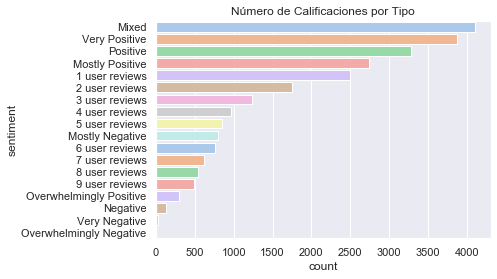

In [21]:
sns.countplot(data = new_data_games, y = 'sentiment', order = new_data_games['sentiment'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

* *Podemos observar, que existe un tipo de calificación `sentiment`, que divide a las reseñas de los juegos entre Muy Positivo y Muy Negativo.*
* *Sin embargo, tenemos dentro de la misma, reseñas que van de 1 user reviews a 9 user reviews, que realmente es poco viable rankear, ya que es difícil dar en éste caso un orden a las mismas.*

5. ¿Cuántos tipos de __calificaciones__ hay (`metascore`)?

In [22]:
pd.unique(new_data_games['metascore'])

array([nan, 96., 84., 80., 76., 70., 69., 81., 75., 72., 66., 67., 77.,
       91., 89., 83., 61., 88., 65., 94., 57., 86., 87., 92., 79., 82.,
       58., 74., 85., 90., 68., 71., 60., 73., 59., 64., 54., 53., 78.,
       51., 44., 63., 38., 56., 49., 52., 62., 93., 48., 34., 95., 43.,
       55., 24., 46., 41., 20., 39., 45., 35., 47., 40., 36., 50., 32.,
       37., 33., 42., 27., 29., 30.])

In [23]:
print(new_data_games['metascore'].value_counts())

80.0    125
74.0    107
77.0    104
75.0    103
76.0    102
       ... 
42.0      1
33.0      1
34.0      1
20.0      1
29.0      1
Name: metascore, Length: 70, dtype: int64


In [24]:
print(new_data_games['metascore'].value_counts().sum())

2607


* *En total tenemos 2607 reseñas a partir de `metascore`.*

Text(0.5, 1.0, 'Número de Calificaciones por Tipo')

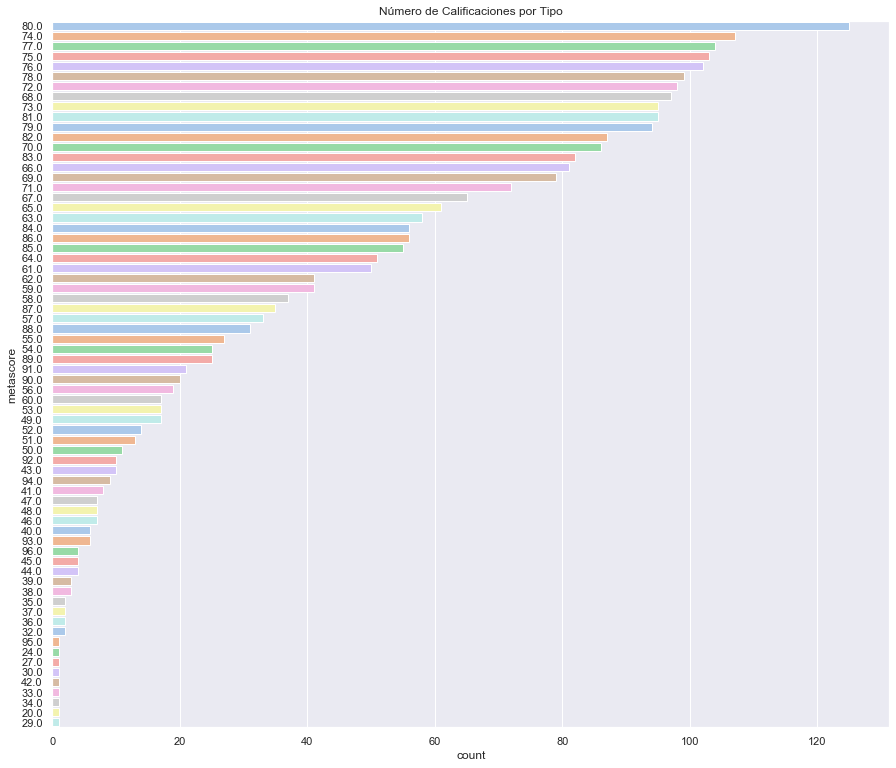

In [25]:
plt.figure(figsize = (15,13))
sns.countplot(data = new_data_games, y = 'metascore', order = new_data_games['metascore'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

* *Si bien `metascore` parece ser una buena forma de darle puntuación a los juegos, la cantidad de calificaciones disponibles es realmente baja en función al dataset total de `reviews`.*
* *En total tenemos 2607 reseñas a partir de `metascore`, lo cual representa un 0,3% del dataset.*

### 4. PREPARACIÓN Y TRANSFORMACIÓN DE DATOS PARA RECOMENDACIÓN COLABORATIVA

* __Recomendación Colaborativa:__ se buscan Usuarios similares al `Usuario X`, y de acuerdo a ello, se usan los productos que ellos consumen para recomendarselos a dicho `Usuario X` (que aún no ha usado, consumido, escuchado, etc.).
    * Ventajas: no necesitamos tener info acerca de los productos.
    * Desventajas: necesitamos tener la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
    
* Necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

CASO PARTICULAR STEAM
* No hay registros tanto en el sitio web Steam, sobre las calificaciones continuas de estos usuarios. En realidad, en la plataforma, los usuarios sólo dan "Recomendación" o "No Recomendación", lo que significa revisiones binarias, positivas y negativas, incluso en el sitio web del usuario, todavía no hay ningún mecanismo sobre las calificaciones continuas como una estrella a cinco estrellas.
* Para obtener calificaciones continuas sobre la interacción entre los usuarios y los juegos, debemos suponer un mecanismo de interacción de calificación de los juegos por parte de los usuarios. Ya que las concentraciones de los usuarios sobre los juegos pueden ser ajustadas por sus `tiempos de juego`, podemos asumir que el tiempo de juego es una información bastante persuasiva sobre los intereses de los usuarios.
* Por lo tanto, __aquí asumimos que el `tiempo de juego` es una parte muy importante de los intereses.__

#### 4.1 DATA REVIEWS

1. Seleccionamos aquellos **features que nos seran útiles** a la hora de realizar las predicciones.

* *Según lo explicado en el punto anterior, en éste caso vamos a considerar los features de `username`, `product_id` y `hours`, ya que son los que nos van a ser útiles a la hora de realizar nuestro filtro colaborativo*.

In [26]:
df = pd.read_csv('new_data_reviews.csv', dtype={'hours': np.float, 'product_id': np.int})
print(df.shape)

(779307, 13)


In [27]:
df1 = df[['username','hours','product_id']]
df1

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


2. __Valores Faltantes:__ visualización y tratamiento.

In [28]:
df1.isnull().sum()

username        18
hours         2637
product_id       0
dtype: int64

* *Los valores fatantes representan menos del 0,3% del total de instancias, por lo que se procede a eliminarlos, ya que no generarían distorsiones en el dataset.*

In [29]:
df2 = df1.dropna()

In [30]:
df2.isnull().sum()

username      0
hours         0
product_id    0
dtype: int64

In [31]:
print(df2.shape)

(776652, 3)


3. __Outliers:__ visualización y tratamiento de valores atípicos en `horas`, la cual será la que utilizaremos luego para elaborar los Ratings.

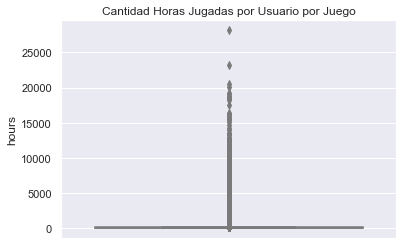

In [32]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df2, y = 'hours', palette= 'pastel')
plt.title('Cantidad Horas Jugadas por Usuario por Juego')
plt.ticklabel_format(axis = 'y', style = 'plain')

* *Se procede a descartar los datos atípicos para `horas`, en éste caso aquellos valores ubicados por encima de 21.000 horas de juego.*

In [33]:
mask_hours = (df2['hours'] <= 21000)
df3 = df2[mask_hours]

df3['hours'].describe()

count    776650.000000
mean        111.766781
std         387.844390
min           0.000000
25%           4.000000
50%          15.300000
75%          59.600000
max       20573.300000
Name: hours, dtype: float64

In [34]:
print(df3.shape)

(776650, 3)


* *El **Dataset Final de Reviews con el que vamos a trabajar**, representa aprox. un **99,7% del Dataset Original Descargado**.*

4. __Encoders:__ aplicación de LabelEncoder s/ `username`.

* *Cada nombre de usuario es **único**, lo cual se refleja en el feature `username` de nuestro dataset.*
* *Si bien Surpr!se puede trabajar con features bajo éstas condiciones, **se decide asignarle un Id a cada usuario único**, a fin de facilitar comparaciones a futuro.*

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df3['username'] = le.fit_transform(df3['username'])
print(df1['username'])

0              Chaos Syren
1                  Ariman1
2              freakfantom
3           The_Cpt_FROGGY
4             the_maker988
                ...       
779302              Vidaar
779303    Nikolai Belinski
779304        RancorZealot
779305               Jerry
779306                Helk
Name: username, Length: 779307, dtype: object


<ipython-input-35-33f375fbccd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['username'] = le.fit_transform(df3['username'])


In [36]:
df3

,username,hours,product_id
0,62380,0.1,725280
1,26824,13.2,328100
2,433537,0.1,725280
3,347055,7.8,631920
4,502628,8.2,35140
...,...,...,...
779302,365956,783.5,252490
779303,241608,55.1,252490
779304,275568,203.5,252490
779305,168334,139.8,252490


* *Como se observa, ahora en la columna de `username`, ahora cada usuario se encuentra representado por un Id Number*

5. __Determinación de Calificaciones:__ confección de un `rating` a partir de las horas jugadas.

* *La cantidad de horas jugadas por cada usuario para cada juego, será en éste caso, determinante a la hora de establecer un ranking de calificaciones.*
* *Se determinan 5 puntuaciones que **van del 1 a 5**, determinadas en función a la distribución de los datos (quintiles), para que en cada una de ellas se hallen una cantidad de valores similares.*

In [37]:
df3['rating'] = pd.qcut(df3.hours, 5, labels=['1', '2', '3', '4', '5'])
print (df3)

<ipython-input-37-561fc2ea2177>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rating'] = pd.qcut(df3.hours, 5, labels=['1', '2', '3', '4', '5'])


        username    hours  product_id rating
0          62380      0.1      725280      1
1          26824     13.2      328100      3
2         433537      0.1      725280      1
3         347055      7.8      631920      2
4         502628      8.2       35140      2
...          ...      ...         ...    ...
779302    365956    783.5      252490      5
779303    241608     55.1      252490      4
779304    275568    203.5      252490      5
779305    168334    139.8      252490      5
779306    147127  15375.0      252490      5

[776650 rows x 4 columns]


In [38]:
df3['rating'].value_counts(normalize=True)

1    0.202744
5    0.199887
4    0.199695
3    0.198839
2    0.198836
Name: rating, dtype: float64

* *Se cumple la simétrica distribución de los datos.*

In [39]:
pd.unique(df3['rating'])

['1', '3', '2', '4', '5']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

<Figure size 432x288 with 0 Axes>

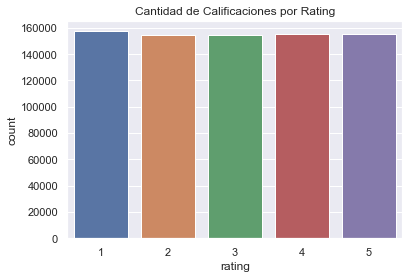

In [40]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=df3, x ='rating')

* *Los valores resultan categóricos, ordenados de menor a mayor.*
* *Los pasamos a enteros, con el fin de poder seguir explorando sus datos.*

In [41]:
df3['rating'] = df3['rating'].astype(int)

<ipython-input-41-90c6f3196ed2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rating'] = df3['rating'].astype(int)


* *Eliminamos la columna de `hours`, dejando en su remplazo la confeccionada de `rating` y reordenamos para una mejor visualización.*

In [42]:
final_reviews = df3[['username','product_id','rating']]
final_reviews

,username,product_id,rating
0,62380,725280,1
1,26824,328100,3
2,433537,725280,1
3,347055,631920,2
4,502628,35140,2
...,...,...,...
779302,365956,252490,5
779303,241608,252490,4
779304,275568,252490,5
779305,168334,252490,5


In [43]:
final_reviews.dtypes

username      int32
product_id    int32
rating        int32
dtype: object

* *Tenemos int32 para todos los features, lo cual nos permitirá un mejor procesamiento de datos en función a la memoria a utilizar.*

* *Obtenemos finalmente el **Dataset de Reviews**, con Usuarios, Id de Productos y Rating, que vamos a utilizar para seguir explorando los datos y sus relaciones con Data Games y además, será la base para entrenar el modelo elegido y realizar las recomendaciones de juegos propuestas.*

In [44]:
if True:
    final_reviews.to_csv('final_reviews.csv', index= False) # Guardamos el Dataset modificado en un nuevo archivo

#### 4.2 DATA GAMES

1. Seleccionamos aquellos **features que nos seran útiles** a la hora de realizar las predicciones.

* *En éste caso, serán útiles las columnas de `title`, para poder identificar el nombre de los juegos, y del `Id` de los juegos, para realizar el cruce de datos con Data Reviews, ya que es éste último el feature, el que tienen en común ambos Datasets.*

In [45]:
df_titulo = pd.read_csv('new_data_games.csv', encoding = "ISO-8859-1", usecols = [4,13])
print(df_titulo.shape)
df_titulo.head()

(32135, 2)


,title,id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,å¼¹ç¸äºº2222,767400.0
4,NaN,773570.0


2. Se **intercambian** las columnas, y se **renombra** la de `id`, a fin de que coincida con el dataset de Reviews.

In [46]:
df_titulo = df_titulo[['id','title']]
df_titulo.head()

,id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN


In [47]:
df_new = df_titulo.rename(columns={'id':'product_id'})
df_new

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


3. __Valores Faltantes:__ visualización y tratamiento.

In [48]:
df_new.isnull().sum()

product_id       2
title         2050
dtype: int64

* *Los valores fatantes representan el 6,4% del total de instancias.*
* *Se procede a eliminar todos ellos, ya que sin `product_id` no podemos cruzar los datos con el dataframe de Reviews, y sin `title` no podremos realizar las recomendaciones.*

In [49]:
df_new_2 = df_new.dropna()

In [50]:
df_new_2

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
5,772540.0,Battle Royale Trainer
...,...,...
32129,745400.0,Kebab it Up!
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads


In [51]:
df_new_2.isnull().sum()

product_id    0
title         0
dtype: int64

* *El **Dataset Final de Games con el que vamos a trabajar**, representa aprox. un **99,9% del Dataset Original Descargado**.*

4. Tratamiento del feature `product_id`, a fin de **indexarla** para realizar el cruce con el Dataset de Reviews en Surpr!se.

In [52]:
df_new_2.dtypes

product_id    float64
title          object
dtype: object

* *Precisamos que el tipo de dato sea entero para `product_id`, para poder realizar su indexación.* 

In [53]:
df_new_2[('product_id')] = df_new_2['product_id'].astype(int)

<ipython-input-53-f03820844022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_2[('product_id')] = df_new_2['product_id'].astype(int)


* *Ahora sí, se indexa la columna `pruduct_id`.*

In [54]:
df_title = df_new_2.set_index('product_id', drop=True)
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer
...,...
745400,Kebab it Up!
773640,Colony On Mars
733530,LOGistICAL: South Africa


In [55]:
df_title.dtypes

title    object
dtype: object

* *Luego, el tipo de dato de `pruduct_id` y `title` resultan ser **object**, siendo correcto para llevar a cabo nuestras recomendaciones a posteriori.*

5. __Eliminación__ de juegos __repetidos__.

* *Se eliminan aquellos valores que se encuentran duplicados en `product_id`, ya que sólo puede haber 1 juego con el mismo Id.*

In [56]:
print(df_title.loc[612880])

                                       title
product_id                                  
612880      Wolfenstein II: The New Colossus
612880      Wolfenstein II: The New Colossus


In [57]:
df_title = df_title[~df_title.index.duplicated(keep='first')]

In [58]:
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer
...,...
745400,Kebab it Up!
773640,Colony On Mars
733530,LOGistICAL: South Africa


* *Sólo había 1 juego duplicado.*

* *Obtuvimos el **Dataset de Games** final, con Usuarios y Id de Productos como Index, para poder realizar el cruce de datos con Reviews, y que será utilizado para los mismos objetivos antes nombrados, es decir, seguir explorando los datos, y servir de base para entrenar el modelo elegido y realizar las recomendaciones de juegos propuestas.*

### 5. EXPLORANDO EL COMPORTAMIENTO DE LOS DATOS Y SU RELACIÓN ENTRE AMBOS DATASETS

* *Nos realizamos distintas preguntan con el fin de realizar un Análisis Exploratorio de Datos más profundo y enfocado a nuestro objetivo de Recomendar Juegos.*

1. ¿Cuántos usuarios únicos hay?

In [59]:
print(len(final_reviews['username'].unique()))

539030


* *539030 usuarios calificaron juegos.*

2. ¿Cuántos juegos únicos hay?

In [60]:
print(len(df_new_2['product_id'].unique())) # Se utiliza df_new_2, porque es donde product_id aún no se encuentra indexado

30083


* *En total se trabajará con 30083 juegos.*

3. Podemos obtener el nombre de un juego dado su `Id`.

In [61]:
product_id = 4574
print(df_new_2.loc[product_id])

product_id                                               406590
title         METAL GEAR SOLID V: THE PHANTOM PAIN - Sneakin...
Name: 4574, dtype: object


In [62]:
product_id = 27432
print(df_new_2.loc[product_id])

product_id                    331930
title         TerraTech R&amp;D Pack
Name: 27432, dtype: object


4. ¿Cuántos juegos calificó cada usuario?

In [63]:
calificaciones_por_usuario = final_reviews.username.value_counts()
calificaciones_por_usuario

5442      213
19123     190
65446     154
240344    142
214778    137
         ... 
120184      1
122233      1
116090      1
128380      1
0           1
Name: username, Length: 539030, dtype: int64

* *La primer columna es el ID del usuario y la segunda, la cantidad de calificaciones que dió.*
* *El usuario 5442 es el que mas calificaciones realizó (juegos jugó), con un total de 213 calificaciones.*

5. ¿Cómo es la distribución del número de calificaciones por usuario?

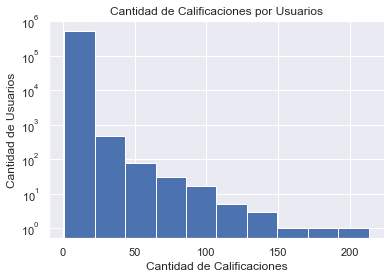

In [64]:
calificaciones_por_usuario.hist(log = True)

plt.xlabel('Cantidad de Calificaciones')
plt.ylabel('Cantidad de Usuarios')
plt.title('Cantidad de Calificaciones por Usuarios')
plt.show()

* *Vemos cuántas calificaciones de juegos realizó cada usuario.*
* *Alrededor del 10% de los usuarios, son los que más calificaciones han realizado (o juegos han jugado).*

6. ¿Cómo es la distribución de los tipos de calificaciones por juego?

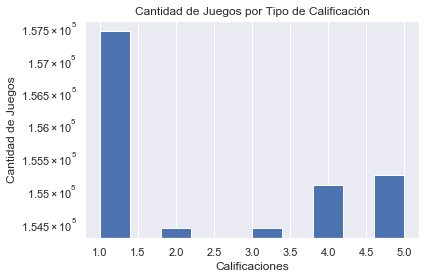

In [65]:
final_reviews['rating'].hist(log= True)

plt.xlabel('Calificaciones')
plt.ylabel('Cantidad de Juegos')
plt.title('Cantidad de Juegos por Tipo de Calificación')
plt.show()

In [66]:
final_reviews['rating'].shape

(776650,)

* *Existen un total de 776650 calificaciones realizadas.*
* *El mayor número de calificaciones, se encuentran alrededor de 1, seguidas de 5 y en tercer lugar 4.*

7. ¿Cuáles son los juegos más populares? ¿Cuántas calificaciones tiene? ¿Y los juegos menos populares?

In [67]:
juegos_por_jugados = final_reviews.product_id.value_counts()
juegos_por_jugados.index = df_title.loc[juegos_por_jugados.index].title
juegos_por_jugados

title
Team Fortress 2                                      18372
Rust                                                 10221
Borderlands 2                                         7319
Fallout 4                                             7112
Grand Theft Auto V                                    5975
                                                     ...  
The Perks of Being a Wallflower                          1
CitiesCorp Concept - Build Everything on Your Own        1
Island Racer                                             1
The Frost                                                1
DP Animation Maker                                       1
Name: product_id, Length: 12620, dtype: int64

* *Se realiza un conteo por juego, de los valores únicos por juego (para c/ Id de juego, cuántos hay).*
* *El juego jugado por mayor cantidad de usuarios, es Team Fortress con 18372 calificaciones.*
* *5 de los juegos jugados 1 sola vez (menos calificados) son The Perks of Being a Wallflower, CitiesCorp Concept - Build Everything on Your Own, Island Racer, Island Racer, The Frost y DP Animation Maker.*

7. ¿Cuál es la calificación promedio de cada juego?

* *Primero, unimos los dataset de reviews y games*

In [68]:
game_data = pd.merge(final_reviews, df_title, on='product_id')
game_data

,username,product_id,rating,title
0,62380,725280,1,Psi Project
1,433537,725280,1,Psi Project
2,26824,328100,3,Gunspell - Steam Edition
3,424473,328100,1,Gunspell - Steam Edition
4,246472,328100,1,Gunspell - Steam Edition
...,...,...,...,...
776645,487385,518790,2,theHunter: Call of the Wildâ¢
776646,115644,518790,4,theHunter: Call of the Wildâ¢
776647,136722,518790,4,theHunter: Call of the Wildâ¢
776648,457985,518790,5,theHunter: Call of the Wildâ¢


* *Observamos los primeros 5 juegos mejor puntuados, en forma descendente.*

In [69]:
game_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Quell Zen                          5.0
Decisive Campaigns: Case Blue      5.0
DJ Streamer                        5.0
City of God I - Prison Empire      5.0
Save Halloween: City of Witches    5.0
Name: rating, dtype: float64

* *Sin embargo, hay un problema. Un juego puede llegar a la cima de la lista anterior incluso si sólo un usuario le ha dado cinco estrellas. Por lo tanto, las estadísticas anteriores pueden ser engañosas. Normalmente, un juego que es realmente buena obtiene una calificación más alta por un gran número de usuarios.*
* *Ahora volvamos a ver el número total de calificaciones de juego:*

In [70]:
game_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Team Fortress 2       18372
Rust                  10221
Borderlands 2          7319
Fallout 4              7112
Grand Theft Auto V     5975
Name: rating, dtype: int64

* *La lista anterior apoya nuestro punto de vista de que los juegos buenos, normalmente reciben mayores calificaciones. Ahora sabemos que tanto la calificación promedio por juego como el número de calificaciones por juego son atributos importantes.*
* *Por lo tanto, creemos un nuevo marco de datos que contenga ambos atributos.*
* *Crearemos un nuevo dataframe de datos llamado `ratings_mean_count` y primero añadiremos la clasificación media de cada juego a este dataframe de datos de la siguiente manera:*

In [71]:
ratings_mean_count = pd.DataFrame(game_data.groupby('title')['rating'].mean())

* *A continuación, añadiremos el número de clasificaciones de un juego al cuadro de datos, con el conteo de la media de clasificaciones.*

In [72]:
ratings_mean_count['rating_counts'] = pd.DataFrame(game_data.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
! That Bastard Is Trying To Steal Our Gold !,1.666667,6
"""Glow Ball"" - The billiard puzzle game",1.600000,5
"""TWO DRAW""",1.000000,1
#monstercakes,2.583333,12
$1 Ride,1.368421,19


* *Podemos ver el título del juego, junto con la calificación promedio y el número de calificaciones de los juegos.*

Text(0.5, 1.0, 'Cantidad de Juegos por Calificación Promedio')

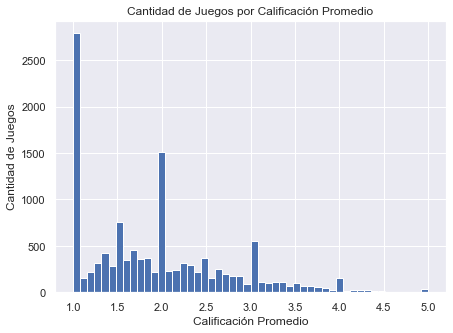

In [73]:
plt.figure(figsize=(7,5))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.xlabel('Calificación Promedio')
plt.ylabel('Cantidad de Juegos')
plt.title('Cantidad de Juegos por Calificación Promedio')

* *Los juegos con un mayor número de valoraciones suelen tener también una valoración media baja.*

## Parte B - Modelo de Machine Learning

### 1. MODELO BENCHMARK: RECOMENDACIÓN BASADA EN CONTENIDO + KNN BASIC

#### 1.1 ENCONTRANDO SIMILITUDES ENTRE JUEGOS

* __Recomendación Basada en Contenido:__ buscar características/atributos/metadatos/info del producto y encontrar similares.
    * Ventajas: sólo se necesita saber del producto que yo consumo y buscar otro que se parezca en base a su contenido, para luego recomendármelo // No es costoso.
    * Desventajas: no siempre es fácil encontrar los productos que buscamos // Suele recomendar items que no son novedosos para el usuario.

* *En el presente análisis, usaremos la **correlación entre las clasificaciones** de un juego como la **métrica de la similitud**.*

* *Utilizaremos el dataset mergeado en el punto anterior **(game_data)**, ya que tiene los features seleccionados de los datasets de reviews y games en uno solo.*
* *Vamos a descartar usuarios con el objetivo de achicar la base de datos. Se realizará de una manera *ad-hoc*.*
* *Descartaremos aquellos usuarios que califican poco (menos de cinco calificaciones) o mucho (más de 5000 calificaciones).*

In [74]:
mask_usuarios_descartables = np.logical_or(game_data.username.value_counts() <= 5, game_data.username.value_counts() > 5000)
usuarios_descartables = mask_usuarios_descartables[mask_usuarios_descartables].index.values
print(len(usuarios_descartables))

530132


In [75]:
mascara_descartables = game_data.username.isin(usuarios_descartables)
print(mascara_descartables.sum())

677863


In [76]:
print(game_data.shape)
game_data = game_data[~mascara_descartables]
print(game_data.shape)

(776650, 4)
(98787, 4)


* *También vamos a descartar también aquellos juegos que tengan pocas calificaciones (menos de 100). Esto, lo hacemos con el objetivo de achicar la matriz de utilidad aún más.*

In [77]:
mask_items_descartables = game_data.product_id.value_counts() <= 100
# mask_items_descartables
items_descartables = mask_items_descartables[mask_items_descartables].index.values
# items_descartables
print(len(items_descartables))

8441


In [78]:
mascara_descartables = game_data.product_id.isin(items_descartables)
print(mascara_descartables.sum())

64068


In [79]:
print(game_data.shape)
metascore_data = game_data[~mascara_descartables]
print(game_data.shape)

(98787, 4)
(98787, 4)


* *Para encontrar la **correlación entre las clasificaciones del juego**, necesitamos crear una matriz donde cada columna sea el nombre del juego y cada fila contenga la clasificación asignada por un usuario específico a ese juego.*
* *Esta matriz tendrá **muchos valores nulos**, ya que cada juego no está clasificado por todos los usuarios.*
* *Crearemos la matriz de títulos de juegos y las correspondientes clasificaciones de los usuarios.*

In [80]:
user_game_rating = game_data.pivot_table(index='username', columns='title', values='rating')
user_game_rating

title,! That Bastard Is Trying To Steal Our Gold !,"""Glow Ball"" - The billiard puzzle game","""TWO DRAW""",#monstercakes,$1 Ride,&gt;observer_,- Arcane RERaise -,- Arcane preRaise -,.EXE,.hack//G.U. Last Recode,...,å®¶æå¤§è² Nekojishi,æ¯æå¤§é­ç2 Rescue the Great Demon 2,æä¹æé¢ The Dark Side Of The Moon,æ±æ¹å¤©ç©ºç ï½ Hidden Star in Four Seasons.,ç«èãCat Meatã,ç¥æçä¸å¤©ä¸ç(God's One Day World),è»è½ åå¤å³ç©¹ä¹æ(The Gate of Firmament),é¾é­æ¶å»,ï¼/realityï¼,ð´ Circles
username,,,,,,,,,,,,,,,,,,,,,
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* *Cada columna contiene todas las clasificaciones de los usuarios de un juego en particular.*

* *Primero, chequeamos cuales son los juegos más populares luego de los filtros.*

In [81]:
game_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Team Fortress 2    1518
Rust               1053
Borderlands 2       745
Fallout 4           640
DayZ                568
Name: rating, dtype: int64

* *`Team Fortress 2` sigue siendo el que más calificaciones tiene, mientras que `Rust` conserva el segundo lugar.*

* *Luego, buscaremos todas las clasificaciones de usuarios para el juego `Team Fortress 2` y encontremos los juegos similares a él.*
* *Escogimos éste juego porque, como se indicó anteriormente, tiene el mayor número de clasificaciones y queremos encontrar la correlación entre los juegos que tienen un mayor número de clasificaciones.*

In [82]:
team_fortress_2_ratings = user_game_rating['Team Fortress 2']
team_fortress_2_ratings.head()

username
89    NaN
117   NaN
163   NaN
176   NaN
203   NaN
Name: Team Fortress 2, dtype: float64

* *Recuperaremos todas los juegos que son similares a `Team Fortress 2`.*
* *Podemos encontrar la correlación entre las clasificaciones de usuario de Team Fortress 2 y todas los demás juegos usando la función corrwith() como se muestra a continuación:*

In [83]:
games_like_team_fortress_2 = user_game_rating.corrwith(team_fortress_2_ratings)

corr_team_fortress_2 = pd.DataFrame(games_like_team_fortress_2, columns=['Correlation'])
corr_team_fortress_2.dropna(inplace=True)
corr_team_fortress_2.head()

C:\Users\Ale\anaconda3\envs\ds\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ale\anaconda3\envs\ds\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
"10,000,000",0.105702
100% Orange Juice,-0.030060
12 Labours of Hercules,-1.000000
12 is Better Than 6,-1.000000
140,-1.000000


* *Ahora, vamos a ordenar los juegos en orden descendente de correlación para ver los jueogs altamente correlacionadas en la parte superior.*

In [84]:
corr_team_fortress_2.sort_values('Correlation', ascending=False).head()

,Correlation
title,
Particle Fleet: Emergence,1.0
Hentai,1.0
Rochard,1.0
Resident Evil Revelations / Biohazard Revelations,1.0
e-River Cabin Journal,1.0


* *Podemos ver que los juegos que tienen una alta correlación con Team Fortress 2 no son muy conocidas.*
* *Esto muestra que la correlación por sí sola no es una buena medida para la similitud porque puede haber un usuario que haya visto Team Fortress 2 y otros pocos juegos y que los haya calificado a todos con 5.*
* *Una solución a este problema es recuperar sólo aquellos juegos correlacionados que tengan al menos más de 50 clasificaciones.*
* *Para ello, añadiremos la columna rating_counts del cuadro de datos rating_mean_count a nuestro cuadro de datos corr_team_fortress_2.*

In [85]:
ratings_mean_count_ = pd.DataFrame(game_data.groupby('title')['rating'].mean())

* *Luego, incorporamos el número de clasificaciones de un juego al cuadro de datos de la cuenta media de clasificaciones.*

In [86]:
ratings_mean_count_['rating_counts'] = pd.DataFrame(game_data.groupby('title')['rating'].count())
ratings_mean_count_.head()

,rating,rating_counts
title,,
! That Bastard Is Trying To Steal Our Gold !,1.500000,2
"""Glow Ball"" - The billiard puzzle game",1.666667,3
"""TWO DRAW""",1.000000,1
#monstercakes,1.500000,4
$1 Ride,1.333333,6


In [87]:
corr_team_fortress_2 = corr_team_fortress_2.join(ratings_mean_count_['rating_counts'])
corr_team_fortress_2.head()

,Correlation,rating_counts
title,,
"10,000,000",0.105702,25
100% Orange Juice,-0.030060,80
12 Labours of Hercules,-1.000000,14
12 is Better Than 6,-1.000000,21
140,-1.000000,36


* *Ahora, filtremos los juegos correlacionados con Team Fortress 2, que tienen más de 50 clasificaciones.*

In [88]:
corr_team_fortress_2[corr_team_fortress_2 ['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Team Fortress 2,1.000000,1518
Doom 3: BFG Edition,0.944911,51
Hearts of Iron IV,0.805554,78
S.T.A.L.K.E.R.: Shadow of Chernobyl,0.792187,62
Darksidersâ¢,0.755322,66


* *Podemos ver los juegos que están altamente correlacionadas con Team Fortress 2.*
* *Los juegos de la lista son todos juegos disparos en primera persona, y como Team Fortress 2 es un juego muy famoso en ese género, hay una alta probabilidad de que estos juegos estén altamente correlacionadas.*
* *Por lo tanto, creamos un simple sistema de recomendación.*

#### 1.2. MODELO BENCHMARK: SURPRISE - KNN BASIC

* *Se elige como Benckmark, un simple algoritmo de filtrado colaborativo basado en memoria, que se deriva directamente de un enfoque básico de vecinos más cercanos.*

In [89]:
reader = Reader()

from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy

data = Dataset.load_from_df(game_data[['username','product_id','rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)

# Se construye el algoritmo y se entrena.
algo_KNN = KNNBasic()
algo_KNN.fit(trainset)
predictions_KNN = algo_KNN.test(testset)
accuracy.rmse(predictions_KNN)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2334


1.2333696207556428

* *Si bien el error obtenido medido a través de RMSE resulta razonable, esperamos obtener un mejor resultado con el modelo elegido SVD, que desarrollaremos en el siguiente apartado.*

### 2. MODELO PREDICTIVO ELEGIDO: RECOMENDACIÓN COLABORATIVA + MODELO SVD

#### 2.1 MODELO PREDICTIVO ELEGIDO: SURPRISE - MODELO SVD

* *Se trabajará con __Surpr!se__ para construir y analizar nuestro sistemas de recomendación, trabajando para ello con datos de calificación explícitos.*
* *El **Modelo de ML elegido es SVD**, basado en factorización matricial.*
* *El **Dataset utilizado** para llevar a cabo el modelo, es el de **final_reviews**, que luego será cruzado con df_title con el fin de visualizar el título de los juegos recomendados, una vez realizadas las predicciones:* 

* *Llevaremos adelante los siguientes pasos:*
    * *Se carga el Dataset.*
    * *Ya aplicamos anteriormente el Reader, para que Surpr!se pueda leer el dataset.*
    * *Se crea el Dataset de Surpr!se usando `Dataset.load_from_df`.*
    * *Se realiza un train_test_split.*
    * *Se entrena un algoritmo SVD.*
    * *Entrenamos sobre el `trainset`.*
    * *Predecimos sobre el `testset`.*
    * *Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a los juegos.*

In [90]:
df_svd = pd.read_csv('final_reviews.csv')
print(df_svd.shape)
df_svd.head()

(776650, 3)


,username,product_id,rating
0,62380,725280,1
1,26824,328100,3
2,433537,725280,1
3,347055,631920,2
4,502628,35140,2


In [91]:
N_filas = 100000 # Limitamos el dataset a N_filas

data_svd = Dataset.load_from_df(df_svd[['username','product_id','rating']][:N_filas], reader)

*Después de las recomendaciones de juegos que incluyen calificaciones de juegos, usamos RMSE como evaluaciones de resultados de nuestras recomendaciones. A medida que se amplíe el conjunto de datos, se mejorarán las evaluaciones de RMSE.*

In [92]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold

# Se define un iterador de validación cruzada
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # Algoritmo train and test.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Calcula e imprime el RMSE
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.0863
RMSE: 1.0896
RMSE: 1.0903


#### 2.2 OPTIMIZACIÓN DE HIPERPARÁMETROS

* *Realizaremos una optimización de hiperparámetros a partir de GridSearch, con el fin de optimizar el modelo elegido lo máximo posible.*

In [93]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[5,25,50], 'n_epochs': [5,10,20], 'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# Mejor RMSE Score
print(gs.best_score['rmse'])

# Combinación de parámetros que dan la mejor puntuación de RMSE
print(gs.best_params['rmse'])

1.0781149661089249
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.002}


* *Aquí estamos evaluando el RMSE promedio en un procedimiento de validación cruzada de 3 veces.*

* *Ahora podemos usar el algoritmo que produce el mejor RMSE.*
* *Tomamos la instancia del algoritmo con el conjunto óptimo de parámetros, y los utilizamos para realizar las predicciones:*

In [104]:
algo_gs = gs.best_estimator['rmse']
algo_gs.fit(data.build_full_trainset())

In [105]:
predictions_gs = algo_gs.test(testset)
accuracy.rmse(predictions_gs, verbose=True)

RMSE: 0.9464


0.9464164842867303

* *El valor del RMSE obtenido con el modelo SVD una vez aplicada la optimización de hiperparámetros, es realmente mejor que el obtenido del modelo Benchmark.*

#### 2.3 COMPARACION ENTRE MODELOS

* Comparación del desempeño de los modelos de ML utilizados con Surpr!se.

| Modelos con Surprise | RMSE |                   Hiperparámetros Utilizados                  |
|:--------------------:|:----:|:-------------------------------------------------------------:|
|       KNN Basic      | 1.23 |             neighbors min = 1, neighbors máx = 40             |
|          SVD         | 0.95 | n_factors = 5, n_epochs = 20, lr_all = 0.005, reg_all = 0.002 |

SVD es el nombre que se le da a un modelo de factor latente que involucra la estimación de parámetros por descenso de gradiente estocástico popularizado por Simon Funk en el contexto de la elaboración de recomendaciones de películas. 

La descomposición de valores singulares es solo un truco matemático para encontrar esas dos matrices más pequeñas que minimizan el error de aproximación resultante, específicamente el error cuadrático medio

Es decir, la SVD ha encontrado nuestras "mejores" generalizaciones para nosotros. 

* *En éste caso, fue **SVD fue el modelo con mejor desempeño**.*
* *Éste resultado, era realmente el esperado, ya que se trata de un algoritmo eficiente y fácil de usar que ofrece un alto rendimiento y precisión en comparación con otros algoritmos.*
* *XGBoost, por otro lado, hace divisiones hasta el max_depth especificado y luego comienza a podar el árbol hacia atrás y elimina las divisiones más allá de las cuales no hay ganancia positiva.*
* *Es por ello que se considera uno de los modelos más eficientes a la hora de realizar predicciones.*
* *Sin embargo, si bien XGBoost tiene una regularización incorporada L1 (Regresión de Lasso) y L2 (Regresión de Ridge) que evita que el modelo se sobreajuste, en nuestro caso se ve algo Sobreajustado, ya que el RMSE Train resulta notablemente inferior que el RMSE de Test.*

#### 2.4 REALIZANDO PREDICCIONES - RECOMENDACIÓN COLABORATIVA

Explorar las característica de `predictions` y alguno de sus elementos

In [120]:
predictions_gs[1] # Predicción para 1 (para un usuario en particular)

# uid: Id del Usuario
# iid: Id del juego
# r_ui: calificación que le da a ese juego en particular (la conocida)
# est: estimación de la calificación (obtenida de SVD)
# was imposible = False: fue posible calificar el juego

Prediction(uid=398896, iid=313120, r_ui=5.0, est=2.8372421060261894, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y un juego en particular, usamos la función `predict`

In [128]:
algo.predict(398896,313120)

Prediction(uid=398896, iid=313120, r_ui=None, est=2.8372421060261894, details={'was_impossible': False})

* r_ui=None: El usuario no la calificó dicho juego.

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

Juegos que le gustaron

In [122]:
usuario = 398896
rating = 4   # le pedimos los juegos a las haya rankeado con 4 o más
df_user = df_svd[(df_svd['username'] == usuario) & (df_svd['rating'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['title'] = df_title['title'].loc[df_user.product_id].values
df_user

,username,product_id,rating,title
0,398896,313120,5,Stranded Deep
1,398896,55230,4,Saints Row: The Third
2,398896,326410,4,Windward


Creamos donde vamos a guardar las recomendaciones para 1 usuario en particular

In [123]:
recomendaciones_usuario = df_title.iloc[:398896].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(30083, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer


Sacamos del dataframe todas los juegos que ya sabemos que vio

In [124]:
usuario_vistas = df_svd[df_svd['username'] == usuario]
print(usuario_vistas.shape)
usuario_vistas

(6, 3)


,username,product_id,rating
173028,398896,313120,5
373933,398896,55230,4
467175,398896,45100,1
593503,398896,91200,3
647201,398896,212680,2
747401,398896,326410,4


Vemos las recomendaciones que ya podemos hacerle a dicho usuario

In [125]:
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,å¼¹ç¸äºº2222
4,772540,Battle Royale Trainer


Y hacemos las recomendaciones, con el Id de juego específico, y ordenados de mayor a menor.  
Abajo la Recomendación con su valor.

In [126]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [127]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))
# Recomendaciones con valuaciones estimadas por debajo

       product_id                             title  Estimate_Score
20948      394360                 Hearts of Iron IV        4.895635
29819         440                   Team Fortress 2        4.746174
23017      377160                         Fallout 4        4.698283
1033          730  Counter-Strike: Global Offensive        4.697263
377         48700        Mount &amp; Blade: Warband        4.663802
2789       250900     The Binding of Isaac: Rebirth        4.650556
24935      271590                Grand Theft Auto V        4.639791
27663      252490                              Rust        4.583078
21610      374320                 DARK SOULSâ¢ III        4.571405
21313      281990                         Stellaris        4.563754


## Parte C - Investigación



FACTORIZACION CON SVD
JUEGO PUNTAJE JUEGO
mostrar que juego jugo cada usuario y que le recomienda el sistema a ese usuario

o	Debes explicar qué te gustaría probar, por qué y cómo lo harías. Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.), debes mencionarlas.
o	Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminares, para ver si estás correctamente orientado.
